# Classification of White blood cells

In this jupyter notebook, we provide an example of how to extract explainable features and run a classification for the imaging flow cytometry dataset provided by:

Classification of Human White Blood Cells Using Machine Learning for Stain-Free Imaging Flow Cytometry https://doi.org/10.1002/cyto.a.23920


We assume you have already installed the library. Otherwise you can install it using 

`!pip -q install <Path to the cloned module>`

This notebook provides an example for deep learning methods

here we import a series of needed modules. 

In [1]:
import scifAI
import numpy as np
from sklearn.datasets import make_classification
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from IPython.core.debugger import Tracer
from torch.utils.data import DataLoader, Dataset
from sklearn.pipeline import Pipeline, FeatureUnion
# Compare Algorithms
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

In [2]:
from scifAI.dl.utils import calculate_weights, train_validation_test_split, get_statistics
from scifAI.dl.dataset import DatasetGenerator
from scifAI.dl.custom_transforms import ShuffleChannel
from scifAI.dl.models import PretrainedModel, resnet18

In [3]:
from iflai.dl.models import PretrainedModel
from skorch.callbacks import LRScheduler,Checkpoint,EpochScoring,EarlyStopping
import torch.optim as optim
from skorch.helper import predefined_split

here, we provide a function for visualizing the result of the confusion matrix which will be used later.

In [4]:
from sklearn.metrics import (plot_confusion_matrix, 
                             matthews_corrcoef, 
                             classification_report,
                             confusion_matrix, 
                             accuracy_score, 
                             balanced_accuracy_score, 
                             cohen_kappa_score, 
                             f1_score,  
                             precision_score, recall_score)
from imblearn.metrics import classification_report_imbalanced

def classification_complete_report(y_true, y_pred, plot = True ): 
    print(classification_report(y_true, y_pred))
    print(15*"----")
    print("matthews correlation coeff: %.2f" % (matthews_corrcoef(y_true, y_pred)) )
    print("Cohen Kappa score: %.2f" % (cohen_kappa_score(y_true, y_pred)) )
    print("Accuracy: %.2f & balanced Accuracy: %.2f" % (accuracy_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)) )
    print("macro F1 score: %.2f & micro F1 score: %.2f" % (f1_score(y_true, y_pred, average = "macro"), f1_score(y_true, y_pred, average = "micro")) )
    print("macro Precision score: %.2f & micro Precision score: %.2f" % (precision_score(y_true, y_pred, average = "macro"), precision_score(y_true, y_pred, average = "micro")) )
    print("macro Recall score: %.2f & micro Recall score: %.2f" % (recall_score(y_true, y_pred, average = "macro"), recall_score(y_true, y_pred, average = "micro")) )
    print(15*"----")
    
    

now lets calculate the metadata:

In [5]:
%%time

data_path = "/pstore/data/DS4/White_blood_cell_dataset/"
metadata = scifAI.metadata_generator(data_path)

Metadata prepration starts...
Experiment_1 Donor_1 condition_1


100%|██████████| 31280/31280 [00:08<00:00, 3787.46it/s]


...metadata prepration ended.
CPU times: user 497 ms, sys: 215 ms, total: 712 ms
Wall time: 8.81 s


In [6]:
metadata

,file,experiment,donor,condition,object_number,set,label
0,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,26659,labeled,CD15+ neutrophil
1,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,30716,labeled,CD15+ neutrophil
2,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,30519,labeled,CD14+ monocyte
3,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,822,labeled,CD15+ neutrophil
4,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,17483,labeled,CD15+ neutrophil
...,...,...,...,...,...,...,...
31275,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,25994,labeled,CD15+ neutrophil
31276,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,3211,labeled,CD8+ T
31277,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,29508,labeled,CD14+ monocyte
31278,/pstore/data/DS4/White_blood_cell_dataset/Expe...,Experiment_1,Donor_1,condition_1,23111,labeled,CD4+ T


['CD15+ neutrophil' 'CD14+ monocyte' 'eosinophil' 'unknown' 'CD4+ T'
 'CD56+ NK' 'NKT' 'CD8+ T' 'CD19+ B']


<AxesSubplot:>

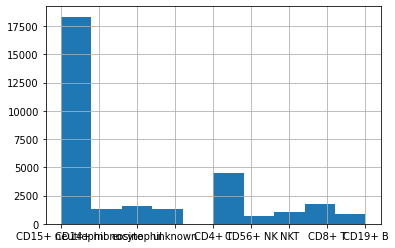

In [7]:
print(metadata.label.unique())
metadata.label.hist()

so we have 31280  files with various labels. first we need to get rid of `unknown` labels

In [8]:
row_index = metadata.label != "unknown"

metadata = metadata.loc[row_index,:].reset_index(drop = True)

lets plot a random image per class

CD14+ monocyte
CD15+ neutrophil
CD19+ B
CD4+ T
CD56+ NK
CD8+ T
NKT
eosinophil


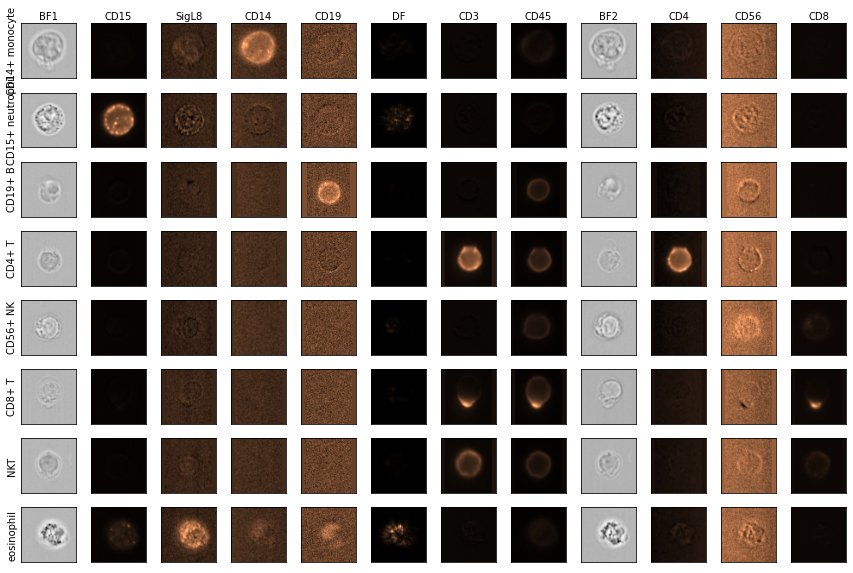

In [9]:
from skimage.util import crop
import h5py

def crop_pad_h_w(image_dummy,reshape_size):
    if image_dummy.shape[0] < reshape_size:
        h1_pad = ( reshape_size - image_dummy.shape[0])/2
        h1_pad = int(h1_pad)
        h2_pad =  reshape_size - h1_pad - image_dummy.shape[0]
        h1_crop = 0
        h2_crop = 0
    else:
        h1_pad = 0
        h2_pad = 0
        h1_crop = ( reshape_size - image_dummy.shape[0])/2
        h1_crop = abs(int(h1_crop))
        h2_crop = image_dummy.shape[0]- reshape_size  - h1_crop

    if image_dummy.shape[1] < reshape_size:
        w1_pad = (reshape_size - image_dummy.shape[1])/2
        w1_pad = int(w1_pad)
        w2_pad = reshape_size - w1_pad - image_dummy.shape[1]
        w1_crop = 0
        w2_crop = 0
    else:
        w1_pad = 0
        w2_pad = 0
        w1_crop = (reshape_size - image_dummy.shape[1])/2
        w1_crop = abs(int(w1_crop))
        w2_crop = image_dummy.shape[1]- reshape_size  - w1_crop

    h = [h1_crop, h2_crop, h1_pad, h2_pad]
    w = [w1_crop, w2_crop, w1_pad, w2_pad] 
    return h, w

def plot_images_with_metadata(metadata,  
                              figsize = None,
                              channels = ["BF","BF", "BF"],
                    channel_colors =  ["Greys", "Oranges", "Blues"],
                    image_size = 128):
    
    metadata_dummy = metadata.copy()
    metadata_dummy = metadata_dummy.reset_index(drop = True)
    
    nrows = len(metadata_dummy)
    ncols = len(channel_colors)
    
    if figsize is None:
        figsize = ( ncols*2, nrows*2 )
    fix,ax = plt.subplots(nrows, ncols, figsize = figsize, tight_layout = True)
    
    vmin = [4095.]*ncols
    vmax = [0.]*ncols
    
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]
        for j, ch in enumerate(range(ncols)):
            vmin[j] = min(vmin[j], image[:,:,ch].min()  )
            vmax[j] = max(vmax[j], image[:,:,ch].max()  )
        
    for i in range(nrows):
        h5_file_ = h5py.File(metadata_dummy.loc[i,"file"], "r")
        image = h5_file_.get("image")[()]         
        
        h, w = crop_pad_h_w(image, image_size)
        h1_crop, h2_crop, h1_pad, h2_pad =  h 
        w1_crop, w2_crop, w1_pad, w2_pad = w 
        for j, ch in enumerate(channel_colors):
            image_dummy = crop(image[:,:,j], ((h1_crop,h2_crop),(w1_crop,w2_crop)))            
            image_dummy = np.pad(image_dummy, 
                                     ((h1_pad,h2_pad),(w1_pad,w2_pad)), 
                                     'constant', 
                                     constant_values = np.mean(image_dummy) )
            ax[i,j].imshow(image_dummy, cmap = channel_colors[j] , vmin = vmin[j], vmax = vmax[j]  )
            ax[i,j].set_xticks([])
            ax[i,j].set_yticks([])
            
            if j == 0:
                print(metadata_dummy.loc[i,"label"])
                ax[i,j].set_ylabel(metadata_dummy.loc[i,"label"])
            if i == 0:
                ax[i,j].set_xlabel(channels[j])
                ax[i,j].xaxis.set_label_position('top') 
            
        h5_file_.close()
    plt.tight_layout()

    
plot_images_with_metadata(metadata.groupby('label').apply(lambda s: s.sample(1, random_state = 2)).reset_index(drop = True) ,  
                              figsize = (12,8),
                          channels = ["BF1", "CD15","SigL8","CD14","CD19","DF","CD3", "CD45","BF2","CD4","CD56","CD8"],
                    channel_colors =  ["Greys", "copper", "copper", "copper", "copper", "copper","copper", "copper","Greys", "copper", "copper", "copper"],
                    image_size = 64)



plt.savefig("Dataset 3 - white blood cells.png", bbox_inches='tight')
plt.savefig("Dataset 3 - white blood cells.svg", bbox_inches='tight')

In [10]:
len(["Greys", "copper", "copper", "copper", "copper", "copper", "copper","Greys", "copper", "copper", "copper"])

11

Set all random seeds to the specific value, so the results are more reproducable

In [11]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

np.random.seed(seed_value)
torch.manual_seed(seed_value)

Define all necessary parameters

In [12]:

model_dir = "models"
log_dir = "logs"
scaling_factor = 255.
reshape_size = 64
train_transform = [
         transforms.RandomVerticalFlip(),
         transforms.RandomHorizontalFlip(),
         transforms.RandomRotation(45)
        ]
test_transform = [ ]
num_classes = len(metadata.label.unique())

In [13]:

selected_channels = np.arange(12)
num_channels = len(selected_channels)
channels = np.asarray(["BF1", "CD15","SigL8","CD14","CD19","DF","CD3", "CD45","BF2","CD4","CD56","CD8"])
num_of_all_channels = len(channels)
all_channels = np.arange(num_of_all_channels)

In [14]:
batch_size = 128
num_workers = 4
device="cuda"

splitting data to train, validaiton and test

In [15]:
train_index, validation_index, test_index = train_validation_test_split(metadata.index, 
                                                                        metadata["label"], 
                                                                        random_state=seed_value)

In [16]:
label_map = dict(zip(sorted(set(metadata.loc[train_index, "label"])), 
                     np.arange(len(set(metadata.loc[train_index, "label"])))))

set_of_interesting_classes = metadata.label.unique().tolist()

label_map

{'CD14+ monocyte': 0,
 'CD15+ neutrophil': 1,
 'CD19+ B': 2,
 'CD4+ T': 3,
 'CD56+ NK': 4,
 'CD8+ T': 5,
 'NKT': 6,
 'eosinophil': 7}

now we calculate the statistics of every channel to later use for nomalizing the dataset

In [17]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(train_transform))

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

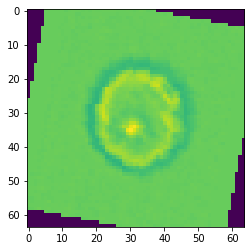

In [19]:
plt.imshow(train_dataset[0][0][0])

In [20]:
statistics = get_statistics(train_loader, selected_channels=selected_channels)

100%|██████████| 150/150 [05:16<00:00,  2.11s/it]

statistics used: {'min': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p01': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p05': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'p25': tensor([3.0834, 0.0522, 0.2235, 0.0784, 0.1137, 0.1451, 0.1647, 0.1263, 3.0325,
        0.1931, 0.0746, 0.1321]), 'p50': tensor([3.1570, 0.0648, 0.2314, 0.0824, 0.1216, 0.1569, 0.1766, 0.1339, 3.0842,
        0.2103, 0.0891, 0.1373]), 'p75': tensor([3.1781, 0.1435, 0.2353, 0.0901, 0.1255, 0.2108, 0.1883, 0.1628, 3.1090,
        0.2259, 0.1008, 0.1412]), 'p95': tensor([3.3563, 1.0603, 0.2510, 0.0987, 0.1341, 0.7985, 0.4381, 0.3929, 3.2917,
        0.2582, 0.1170, 0.1518]), 'p99': tensor([3.7218, 1.8997, 0.2928, 0.1543, 0.1448, 1.6570, 1.1371, 0.6682, 3.6521,
        0.4434, 0.1314, 0.2308]), 'max': tensor([ 5.7525, 14.4005,  0.8524,  0.5409,  0.3499, 12.7437,  4.7699,  2.1468,
         5.8467,  1.5191,  0.4298,  1.1939]), 'mean': tensor([2.7759, 0.2225, 0.2063, 0.0766, 0

adding the normalization to each transform

In [21]:
train_transform.append(transforms.Normalize(mean=statistics["mean"],
                         std=statistics["std"]))

test_transform.append(transforms.Normalize(mean=statistics["mean"],
                         std=statistics["std"]))

In [22]:
train_loader = None

defining train, validation and test datasets

In [23]:
train_dataset = DatasetGenerator(metadata=metadata.loc[train_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor, 
                                 reshape_size=reshape_size,
                                 transform= transforms.Compose(train_transform))

validation_dataset = DatasetGenerator(metadata=metadata.loc[validation_index,:],
                                      label_map=label_map,
                                      selected_channels=selected_channels,
                                      scaling_factor=scaling_factor,
                                      reshape_size=reshape_size,
                                      transform=transforms.Compose(test_transform))
test_dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                label_map=label_map,
                                selected_channels=selected_channels,
                                scaling_factor=scaling_factor,
                                reshape_size=reshape_size,
                                transform=
                                transforms.Compose(test_transform))

considering that we have multiple input channels, we need to modify the ResNet18 network input layer

In [24]:
import torch.nn as nn
from scifAI.dl.models import PretrainedModel
import torch.nn.functional as F

resnet18_modified = PretrainedModel(num_channels= len(selected_channels),
                                     num_classes = len(set_of_interesting_classes), 
                                     pretrained = True)

In [25]:
resnet18_modified

PretrainedModel(
  (model): ResNet(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=

finally, we add a scheduler and an early stopping based on valid_f1_macro

In [26]:
lr_scheduler = LRScheduler(policy='ReduceLROnPlateau', factor=0.1, patience=10)

epoch_scoring = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

epoch_scoring = EpochScoring("f1_macro", 
                             name =  "valid_f1_macro", 
                             on_train = False,
                             lower_is_better = False)

early_stopping = EarlyStopping(monitor='valid_f1_macro', 
                               patience=20, 
                               threshold=0.0001, 
                               threshold_mode='rel', 
                               lower_is_better=False)

lets define and train the model using `skorch`

In [27]:
net = NeuralNetClassifier(    
    resnet18_modified, 
    criterion=nn.CrossEntropyLoss,
    lr=0.001,
    batch_size=batch_size,
    max_epochs=1000,
    optimizer=optim.AdamW,
    iterator_train__shuffle=True,
    iterator_train__num_workers=num_workers,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=2,
    callbacks=[lr_scheduler, epoch_scoring, early_stopping],
    train_split=predefined_split(validation_dataset),
    device="cuda",
    warm_start=True)

In [28]:
net = net.fit(train_dataset, y = None)

  epoch    train_loss    valid_acc    valid_f1_macro    valid_loss      dur
-------  ------------  -----------  ----------------  ------------  -------
      1        0.1115       0.9921            0.9748        0.0373  34.6951
      2        0.0587       0.9575            0.8896        0.0996  34.5747
      3        0.0394       0.9925            0.9796        0.0243  34.7663
      4        0.0479       0.9166            0.9074        0.3269  34.7283
      5        0.0320       0.9394            0.8186        0.1557  34.7996
      6        0.0303       0.9935            0.9823        0.0244  35.2259
      7        0.0279       0.9942            0.9841        0.0251  35.2073
      8        0.0340       0.9944            0.9840        0.0217  34.9431
      9        0.0312       0.9431            0.8335        0.1229  34.8187
     10        0.0257       0.9935            0.9809        0.0214  34.8828
     11        0.0255       0.9944            0.9842        0.0200  35.1252
     12     

lets take a look the prediction pefromance fore the validation set

In [29]:
inv_label_map = {v: k for k, v in label_map.items()}

preds = net.predict(validation_dataset)
preds =  [inv_label_map[int(t)] for t in preds]

classification_complete_report(validation_dataset.metadata.label, 
                               preds  )

                  precision    recall  f1-score   support

  CD14+ monocyte       0.99      1.00      1.00       205
CD15+ neutrophil       1.00      1.00      1.00      2932
         CD19+ B       1.00      1.00      1.00       142
          CD4+ T       1.00      1.00      1.00       716
        CD56+ NK       1.00      0.98      0.99       107
          CD8+ T       0.97      0.99      0.98       286
             NKT       0.98      0.93      0.96       165
      eosinophil       1.00      1.00      1.00       246

        accuracy                           1.00      4799
       macro avg       0.99      0.99      0.99      4799
    weighted avg       1.00      1.00      1.00      4799

------------------------------------------------------------
matthews correlation coeff: 0.99
Cohen Kappa score: 0.99
Accuracy: 1.00 & balanced Accuracy: 0.99
macro F1 score: 0.99 & micro F1 score: 1.00
macro Precision score: 0.99 & micro Precision score: 1.00
macro Recall score: 0.99 & micro Recall 

and finally for the test set

In [30]:
preds = net.predict(test_dataset)
preds =  [inv_label_map[int(t)] for t in preds]

classification_complete_report(test_dataset.metadata.label, 
                               preds  )

                  precision    recall  f1-score   support

  CD14+ monocyte       0.99      1.00      0.99       256
CD15+ neutrophil       1.00      1.00      1.00      3665
         CD19+ B       0.99      1.00      1.00       178
          CD4+ T       0.99      1.00      0.99       895
        CD56+ NK       1.00      0.98      0.99       134
          CD8+ T       0.97      0.99      0.98       358
             NKT       0.96      0.90      0.93       206
      eosinophil       0.98      1.00      0.99       307

        accuracy                           0.99      5999
       macro avg       0.99      0.98      0.98      5999
    weighted avg       0.99      0.99      0.99      5999

------------------------------------------------------------
matthews correlation coeff: 0.99
Cohen Kappa score: 0.99
Accuracy: 0.99 & balanced Accuracy: 0.98
macro F1 score: 0.98 & micro F1 score: 0.99
macro Precision score: 0.99 & micro Precision score: 0.99
macro Recall score: 0.98 & micro Recall 

In [31]:
model = net.module_

### Model Interpretation

In [32]:
# where to save results
model_name = "resnet18"
dataset_name = "white blood cells"

#### Pixel-Permutation Tests

In [33]:
from time import process_time

In [34]:
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [35]:
correct = 0.
total = 0.
y_true = list()
y_pred = list()
y_true_proba = list()
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device).float(), data[1].to(device).long()
        #Tracer()()
        outputs = model(inputs)
        pred = outputs.argmax(dim=1)
        true_proba = np.array([j[i] for (i,j) in zip(pred, outputs.cpu())])
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels.reshape(-1) == predicted).sum().item()
        for i in range(len(pred)):
            y_true.append(labels[i].item())
            y_pred.append(pred[i].item())
            y_true_proba.append(true_proba[i].item())

In [36]:
class_names_targets = [c for c in label_map.keys()]

In [37]:
print(classification_report(y_true, y_pred, target_names=class_names_targets, digits=2))

                  precision    recall  f1-score   support

  CD14+ monocyte       0.99      1.00      0.99       256
CD15+ neutrophil       1.00      1.00      1.00      3665
         CD19+ B       0.99      1.00      1.00       178
          CD4+ T       0.99      1.00      0.99       895
        CD56+ NK       1.00      0.98      0.99       134
          CD8+ T       0.97      0.99      0.98       358
             NKT       0.96      0.90      0.93       206
      eosinophil       0.98      1.00      0.99       307

        accuracy                           0.99      5999
       macro avg       0.99      0.98      0.98      5999
    weighted avg       0.99      0.99      0.99      5999



100%|██████████| 100/100 [10:43<00:00,  6.43s/it]


Candidate channel  to remove is 0


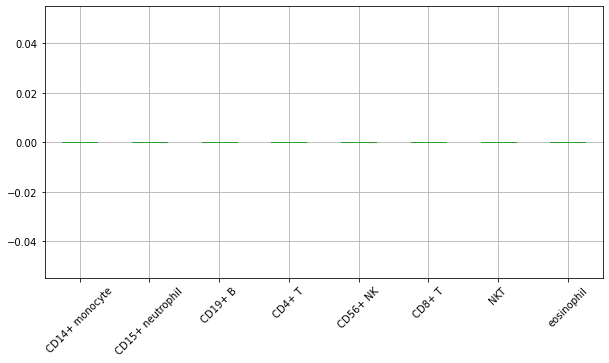

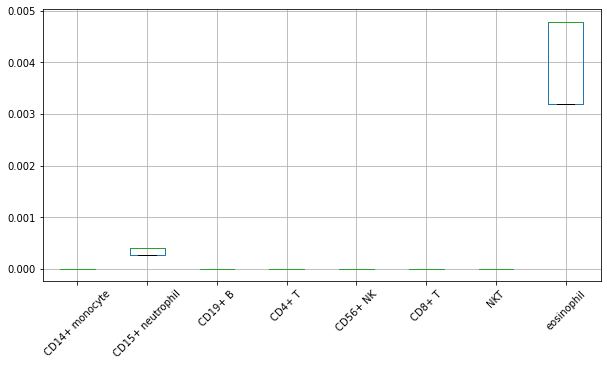

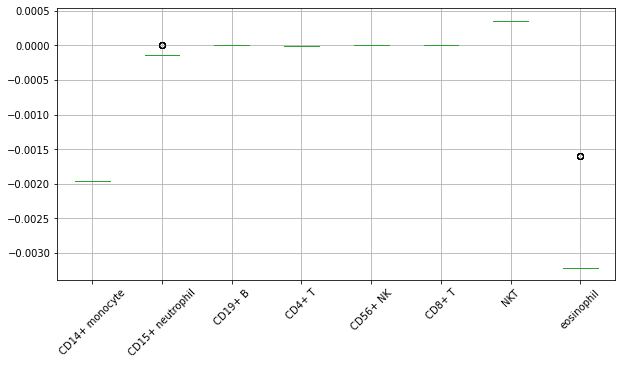

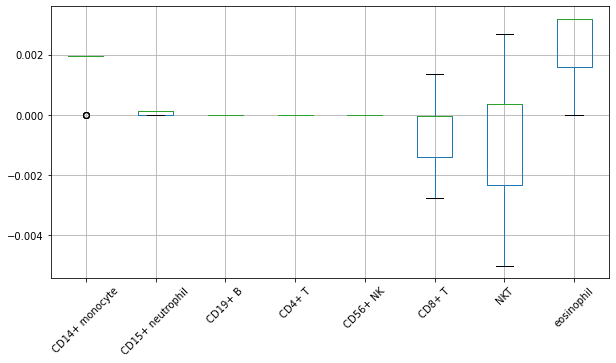

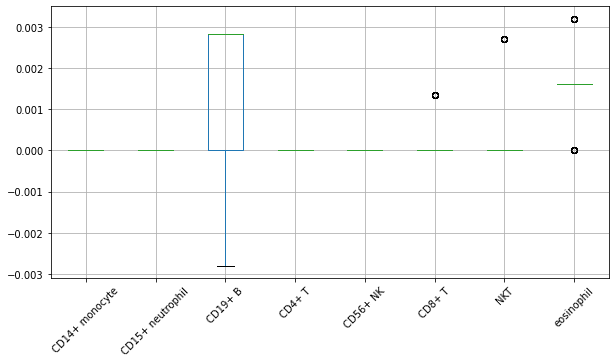

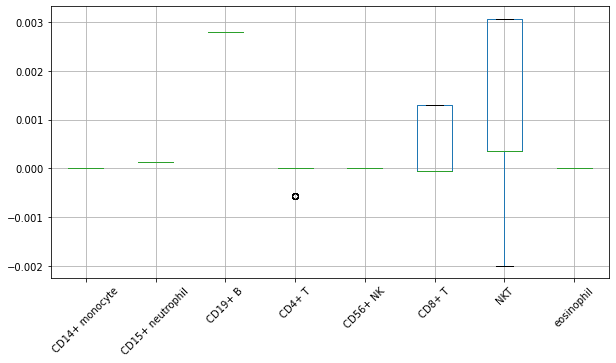

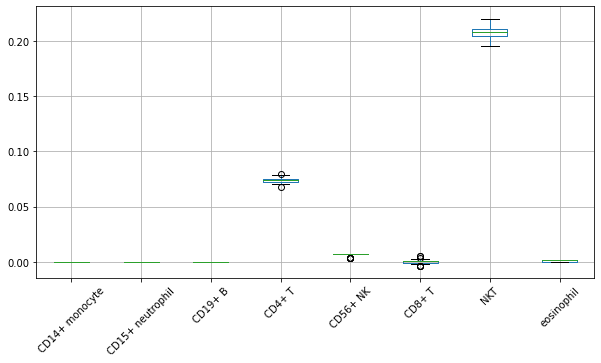

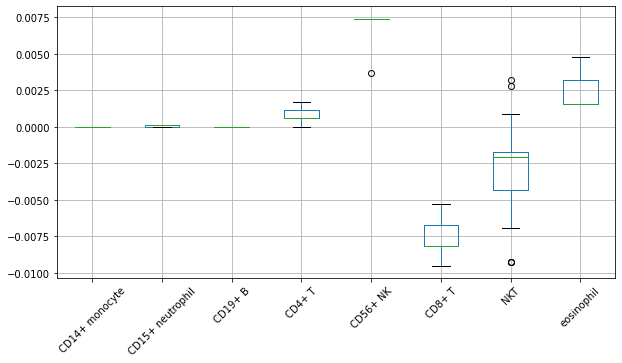

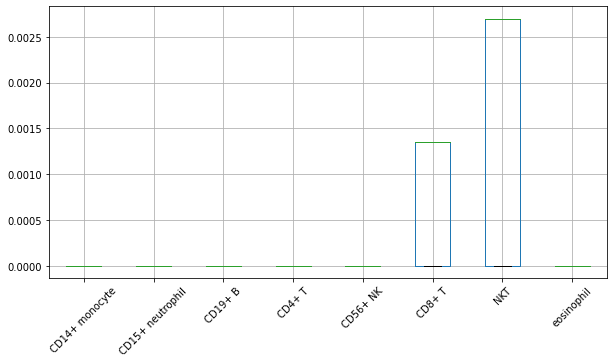

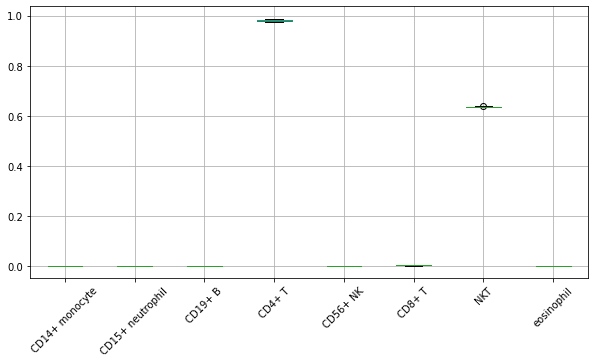

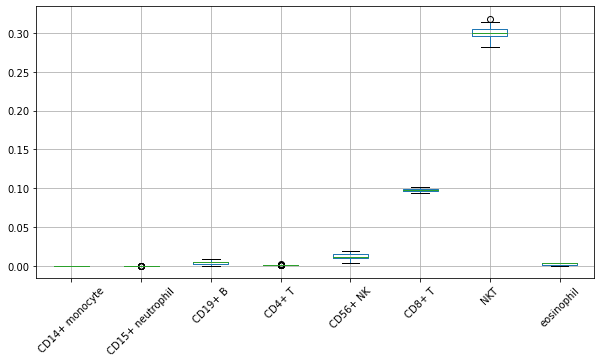

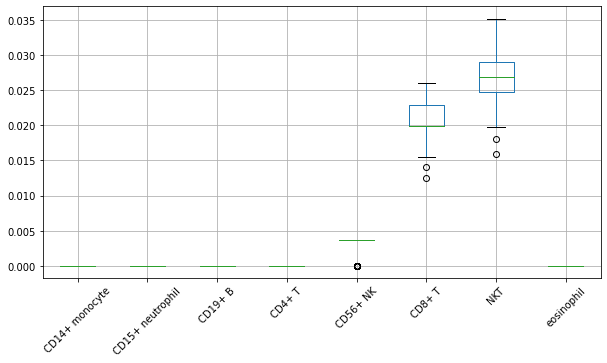

In [38]:
t1_start = process_time()
f1_score_original = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
min_mean_dif = 1.0
candidate = 0
shuffle_times = 100
df_all = pd.DataFrame([], columns=class_names_targets)
for c in range(num_channels):
    f1_score_diff_from_original_per_channel_per_shuffle = []
    transform = test_transform.copy()
    transform.append(ShuffleChannel(channels_to_shuffle=[c]))
    for s in tqdm(range(shuffle_times)):
        dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                 label_map=label_map,
                                 selected_channels=selected_channels,
                                 scaling_factor=scaling_factor,
                                 reshape_size=reshape_size,
                                 transform=transforms.Compose(transform))
        dataloader = DataLoader(dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=num_workers)
        y_true = list()
        y_pred = list()
        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
                outputs = model(inputs)
                pred = outputs.argmax(dim=1)
                for i in range(len(pred)):
                    y_true.append(labels[i].item())
                    y_pred.append(pred[i].item())
            f1_score_per_channel = f1_score(y_true, y_pred, average=None, labels=np.arange(num_classes))
            f1_score_diff_from_original_per_channel_per_shuffle.append(f1_score_original - f1_score_per_channel)
    mean_along_columns = np.mean(f1_score_diff_from_original_per_channel_per_shuffle, axis=0)
    mean_dif = np.mean(mean_along_columns)
    if mean_dif < min_mean_dif and mean_dif > 0 and not selected_channels[c]:
        min_mean_dif = mean_dif
        candidate = selected_channels[c]
    df_diff = pd.DataFrame(np.atleast_2d(f1_score_diff_from_original_per_channel_per_shuffle), columns=class_names_targets)
    df_mean_diff = pd.DataFrame(np.atleast_2d(mean_along_columns), columns=class_names_targets)
    df_all = pd.concat([df_all, df_mean_diff], ignore_index=True, sort=False)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax = df_diff.boxplot()
    ax.set_xticklabels(class_names_targets, rotation=45)
    #fig.savefig(os.path.join("results",model_name, "{}-shuffle_method-model-{}-channel-{}.png".format(dataset_name, str(model_name), str(selected_channels[c]))))
print("Candidate channel  to remove is {}".format(candidate))

<BarContainer object of 12 artists>

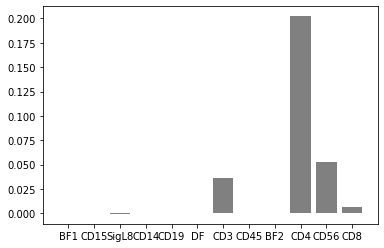

In [39]:
plt.bar(channels[selected_channels], df_all.T.mean(), color='Grey')
#plt.savefig(os.path.join("results",model_name, "{}-pixel-permutation-method-model-all-{}.svg".format(dataset_name, str("resnet_all"))))

In [40]:
channel_ranking_pixel_permutation = pd.DataFrame(data={'channels': channels[np.asarray(selected_channels)], 'importance': df_all.T.mean().to_numpy()})

In [41]:
from captum.attr import (
    GuidedGradCam,
    DeepLift,
    Saliency,
    DeepLiftShap,
    GradientShap,
    InputXGradient,
    IntegratedGradients,
    GuidedBackprop,
    Deconvolution,
    Occlusion,
    FeaturePermutation,
    ShapleyValueSampling,
    Lime,
    KernelShap,
    LRP
)
from time import process_time

In [42]:
def run_interpretation_method(ablator, method_name, require_baseline=False, require_sliding_window=False):
    t1_start = process_time()
    dataset = DatasetGenerator(metadata=metadata.loc[test_index,:],
                                     label_map=label_map,
                                     selected_channels=selected_channels,
                                     scaling_factor=scaling_factor,
                                     reshape_size=reshape_size,
                                     transform=transforms.Compose(test_transform))
    testloader = DataLoader(test_dataset,
                                    batch_size=batch_size,
                                    shuffle=False,
                                    num_workers=num_workers)

    heatmaps = torch.empty(0, dtype=torch.float32, device=device)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device).float(), data[1].to(device).reshape(-1).long()
            if require_baseline:
                baselines=torch.zeros(inputs.shape).to(device)
                attr = ablator.attribute(inputs, target=labels, baselines=baselines)
            elif require_sliding_window:
                attr = ablator.attribute(inputs, target=labels, sliding_window_shapes=(1,3,3))
            else:
                attr = ablator.attribute(inputs, target=labels)
            heatmaps = torch.cat((heatmaps,  torch.from_numpy(np.percentile(torch.flatten(attr, start_dim=-2).cpu().numpy(), q=50, axis=-1)).to(device)))
    heatmaps_mean = torch.mean(heatmaps, dim=0)
    plt.bar(channels, heatmaps_mean.cpu(), color='grey')
    #plt.savefig(os.path.join("results", "resnet_all", "{}-{}_method-model-50-percentile-{}.png".format(dataset_name, method_name, str("resnet_all"))))

    t1_stop = process_time()
    print("Elapsed time:", t1_stop, t1_start) 

    print("Elapsed time during the whole program in seconds:",
                                             t1_stop-t1_start)
    return heatmaps_mean

In [43]:
# DeepLift

Elapsed time: 3234.340876368 3221.997150048
Elapsed time during the whole program in seconds: 12.34372631999986


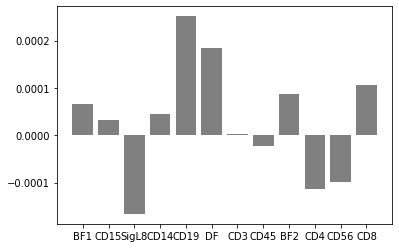

In [44]:
dl = DeepLift(model)
heatmaps_deeplift_mean = run_interpretation_method(dl, 'dl')

In [45]:
# Saliency

Elapsed time: 3245.050041018 3234.489009595
Elapsed time during the whole program in seconds: 10.561031422999804


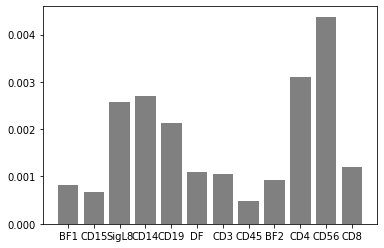

In [46]:
saliency = Saliency(model)
heatmaps_saliency_mean = run_interpretation_method(saliency, 'saliency')

In [47]:
# IntegratedGradients

Elapsed time: 3338.719589365 3245.201717242
Elapsed time during the whole program in seconds: 93.51787212299996


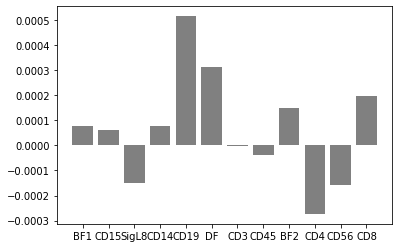

In [48]:
ig = IntegratedGradients(model)
heatmaps_integrated_gradient_mean = run_interpretation_method(ig, 'IntegratedGradients')

In [49]:
# LRP

Elapsed time: 3350.042024275 3338.898712544
Elapsed time during the whole program in seconds: 11.143311731000267


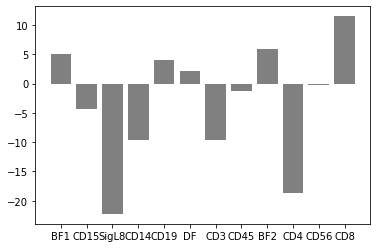

In [50]:
lrp = LRP(model)
heatmaps_lrp_mean = run_interpretation_method(lrp, 'LRP')

In [51]:
# GuidedGradCAM

Elapsed time: 3360.243555265 3350.201408004
Elapsed time during the whole program in seconds: 10.042147261000082


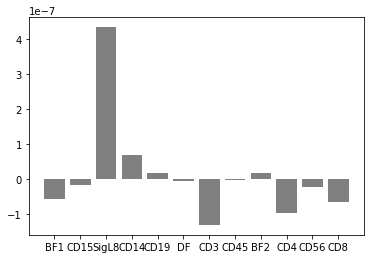

In [52]:
guided_cram = GuidedGradCam(model, model.model.layer1)
heatmaps_gradcam_mean = run_interpretation_method(guided_cram, 'GuidedGradCam')

5fold CV on the data and get the importance per fold for statistical evaluation
    
our result is in alignment with the original paper. On the other hand, guided gradcam failed